# Dual Momentum Investing

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime

from utils import historic_cdi

In [2]:
IBOV = yf.Ticker('^BVSP')
SP500 = yf.Ticker('^GSPC')

### IBOV

In [3]:
ibov_prices = IBOV.history(period='max', rounding=True)['Close']
ibov_prices.index = pd.to_datetime(ibov_prices.index).date

ibov_prices

1993-04-27        24.5
1993-04-28        24.3
1993-04-29        23.7
1993-04-30        24.1
1993-05-03        24.1
                ...   
2024-08-26    136889.0
2024-08-27    136776.0
2024-08-28    137344.0
2024-08-29    136041.0
2024-08-30    136004.0
Name: Close, Length: 7762, dtype: float64

In [4]:
# cálculo da cota

ibov = ibov_prices.div(ibov_prices.iloc[0])

ibov

1993-04-27       1.000000
1993-04-28       0.991837
1993-04-29       0.967347
1993-04-30       0.983673
1993-05-03       0.983673
                 ...     
2024-08-26    5587.306122
2024-08-27    5582.693878
2024-08-28    5605.877551
2024-08-29    5552.693878
2024-08-30    5551.183673
Name: Close, Length: 7762, dtype: float64

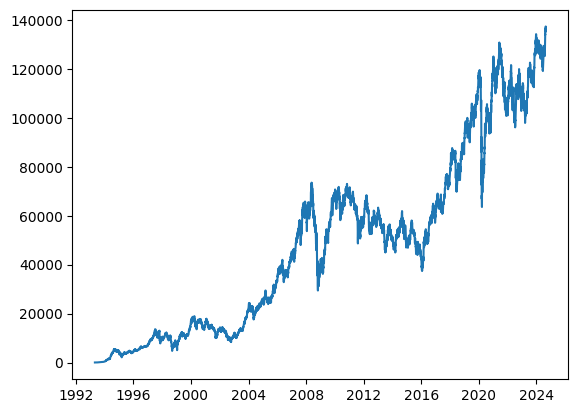

In [5]:
plt.plot(ibov_prices)
plt.show()

In [6]:
# variação diária do índice

ibov_prices_var = ibov_prices.pct_change()
ibov_prices_var = ibov_prices_var[1:len(ibov_prices_var.index)]

ibov_prices_var

1993-04-28   -0.008163
1993-04-29   -0.024691
1993-04-30    0.016878
1993-05-03    0.000000
1993-05-04    0.033195
                ...   
2024-08-26    0.009446
2024-08-27   -0.000825
2024-08-28    0.004153
2024-08-29   -0.009487
2024-08-30   -0.000272
Name: Close, Length: 7761, dtype: float64

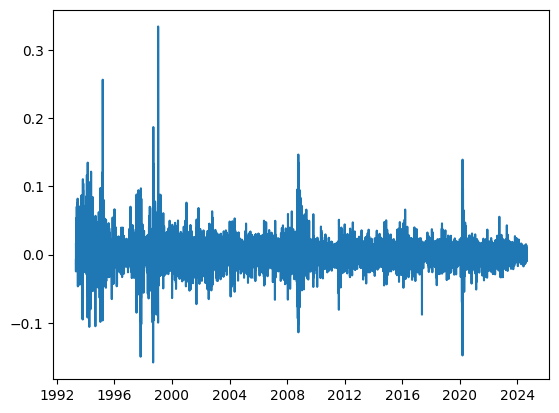

In [7]:
plt.plot(ibov_prices_var)
plt.show()

In [8]:
# retorno médio anualizado

ibov_avg_return = np.mean(ibov_prices_var) * 252

ibov_avg_return

np.float64(0.33840483205427324)

In [9]:
# drawdown

ibov_cum_returns = (1 + ibov_prices_var).cumprod()
ibov_cum_max = ibov_cum_returns.cummax()

drawdown = (ibov_cum_returns - ibov_cum_max) / ibov_cum_max

drawdown

1993-04-28    0.000000
1993-04-29   -0.024691
1993-04-30   -0.008230
1993-05-03   -0.008230
1993-05-04    0.000000
                ...   
2024-08-26    0.000000
2024-08-27   -0.000825
2024-08-28    0.000000
2024-08-29   -0.009487
2024-08-30   -0.009757
Name: Close, Length: 7761, dtype: float64

In [10]:
round(min(drawdown), 2)

-0.65

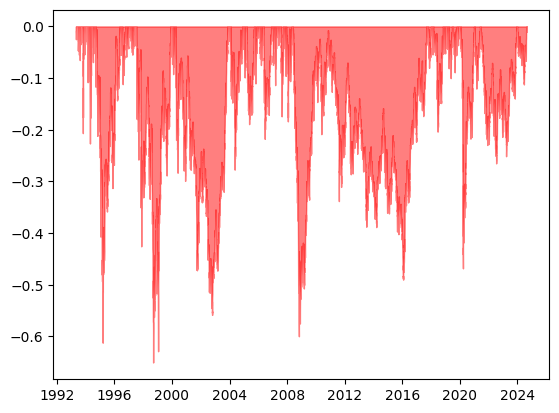

In [11]:
plt.fill_between(x=drawdown.index, y1=drawdown, color='red', alpha=0.5)
plt.show()

In [12]:
ibov_drawdown_shifts = (drawdown < 0).ne((drawdown < 0).shift()).cumsum()
ibov_drawdown_durations = (drawdown < 0).groupby(ibov_drawdown_shifts).size()

print(round(ibov_drawdown_durations.mean()))
print(ibov_drawdown_durations.max())

18
2304


### Absolute Momentum

In [13]:
start_date = datetime.strftime(ibov_prices.index.min(), format='%d/%m/%Y')
end_date = datetime.strftime(ibov_prices.index.max(), format='%d/%m/%Y')

In [14]:
cdi = historic_cdi(start=start_date, end=end_date)
cdi = cdi.div(cdi.iloc[0])

cdi

1993-04-27       1.000000
1993-04-28       1.013950
1993-04-29       1.027888
1993-04-30       1.041693
1993-05-03       1.055360
                 ...     
2024-08-26    9723.959908
2024-08-27    9727.778507
2024-08-28    9731.598606
2024-08-29    9735.420204
2024-08-30    9739.243304
Name: valor, Length: 7868, dtype: float64

In [49]:
returns = pd.concat([ibov, cdi], keys=['IBOV', 'CDI'],  axis=1, join='inner')
returns.index = pd.to_datetime(returns.index)

returns.sort_index()

,IBOV,CDI
1993-04-27,1.000000,1.000000
1993-04-28,0.991837,1.013950
1993-04-29,0.967347,1.027888
1993-04-30,0.983673,1.041693
1993-05-03,0.983673,1.055360
...,...,...
2024-08-26,5587.306122,9723.959908
2024-08-27,5582.693878,9727.778507
2024-08-28,5605.877551,9731.598606
2024-08-29,5552.693878,9735.420204


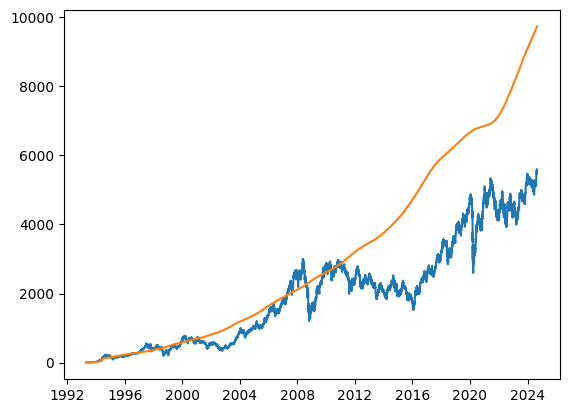

In [50]:
plt.plot(returns)
plt.show()

In [51]:
yearly_performance = returns.pct_change(periods=252).dropna()

yearly_performance

,IBOV,CDI
1994-05-04,63.236735,53.331335
1994-05-05,58.584362,53.527809
1994-05-06,62.725738,53.737763
1994-05-09,57.995851,53.966235
1994-05-10,63.232365,54.221954
...,...,...
2024-08-26,0.178493,0.114061
2024-08-27,0.157794,0.113952
2024-08-28,0.173620,0.113843
2024-08-29,0.174418,0.113735


In [52]:
yearly_performance['Excess Return'] = yearly_performance.apply(lambda x: 'IBOV' if x['IBOV'] > x['CDI'] else 'CDI', axis=1)

yearly_performance['Excess Return'].value_counts()

Excess Return
CDI     3812
IBOV    3695
Name: count, dtype: int64

In [63]:
first_trading_day = yearly_performance.index.to_series().groupby(yearly_performance.index.to_period('M')).apply(lambda x: x == x.min())

yearly_performance['Month Start'] = first_trading_day.values

yearly_performance

,IBOV,CDI,Excess Return,Month Start
1994-05-04,63.236735,53.331335,IBOV,True
1994-05-05,58.584362,53.527809,IBOV,False
1994-05-06,62.725738,53.737763,IBOV,False
1994-05-09,57.995851,53.966235,IBOV,False
1994-05-10,63.232365,54.221954,IBOV,False
...,...,...,...,...
2024-08-26,0.178493,0.114061,IBOV,False
2024-08-27,0.157794,0.113952,IBOV,False
2024-08-28,0.173620,0.113843,IBOV,False
2024-08-29,0.174418,0.113735,IBOV,False


In [68]:
yearly_performance['Investment'] = yearly_performance.loc[yearly_performance['Month Start'], 'Excess Return']
yearly_performance['Investment'] = yearly_performance['Investment'].ffill()

yearly_performance

,IBOV,CDI,Excess Return,Month Start,Investment
1994-05-04,63.236735,53.331335,IBOV,True,IBOV
1994-05-05,58.584362,53.527809,IBOV,False,IBOV
1994-05-06,62.725738,53.737763,IBOV,False,IBOV
1994-05-09,57.995851,53.966235,IBOV,False,IBOV
1994-05-10,63.232365,54.221954,IBOV,False,IBOV
...,...,...,...,...,...
2024-08-26,0.178493,0.114061,IBOV,False,CDI
2024-08-27,0.157794,0.113952,IBOV,False,CDI
2024-08-28,0.173620,0.113843,IBOV,False,CDI
2024-08-29,0.174418,0.113735,IBOV,False,CDI


In [80]:
returns_var = returns.pct_change().dropna()

absolute_momentum = returns_var.merge(yearly_performance[['Investment']], left_index=True, right_index=True,  how='right')

absolute_momentum['Absolute Momentum'] = absolute_momentum['IBOV']

absolute_momentum.loc[absolute_momentum['Investment'] != 'IBOV', 'Absolute Momentum'] = absolute_momentum['CDI']

absolute_momentum

,IBOV,CDI,Investment,Absolute Momentum
1994-05-04,-0.045256,0.017610,IBOV,-0.045256
1994-05-05,-0.079997,0.017617,IBOV,-0.079997
1994-05-06,0.043097,0.017650,IBOV,0.043097
1994-05-09,-0.058598,0.017660,IBOV,-0.058598
1994-05-10,0.088761,0.017833,IBOV,0.088761
...,...,...,...,...
2024-08-26,0.009446,0.000393,CDI,0.000393
2024-08-27,-0.000825,0.000393,CDI,0.000393
2024-08-28,0.004153,0.000393,CDI,0.000393
2024-08-29,-0.009487,0.000393,CDI,0.000393


In [85]:
absolute_momentum_eval = (1 + absolute_momentum.drop(columns=['Investment'])).cumprod()

absolute_momentum_eval

,IBOV,CDI,Absolute Momentum
1994-05-04,0.954744,1.017610,0.954744
1994-05-05,0.878367,1.035537,0.878367
1994-05-06,0.916222,1.053814,0.916222
1994-05-09,0.862533,1.072424,0.862533
1994-05-10,0.939092,1.091549,0.939092
...,...,...,...
2024-08-26,83.043557,182.126924,243.967879
2024-08-27,82.975006,182.198445,244.063685
2024-08-28,83.319583,182.269994,244.159529
2024-08-29,82.529119,182.341572,244.255410


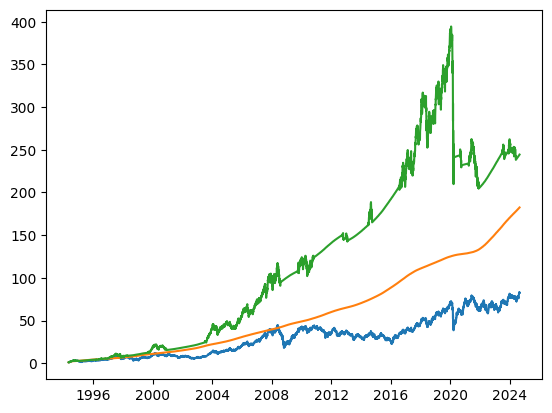

In [86]:
plt.plot(absolute_momentum_eval)
plt.show()